<a href="https://colab.research.google.com/github/rakibulhaque9954/Sec-19-object-detection-YOLO/blob/main/sec_19_object_dectection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [65]:
import tensorflow as tf### models
import numpy as np### math computations
import seaborn as sns### visualizations
import matplotlib.pyplot as plt### plotting bar chart
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET
import os
import shutil
import cv2
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
from keras.models import Model
from keras.layers import Layer
from keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from keras.regularizers import L2, L1
from keras.initializers import RandomNormal

# Dataset Download


In [6]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d huanghanchina/pascal-voc-2012

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 3.61G/3.63G [00:43<00:00, 139MB/s]
100% 3.63G/3.63G [00:43<00:00, 90.1MB/s]


In [7]:
val_list=['2007_000027.jpg','2007_000032.jpg','2007_000033.jpg','2007_000039.jpg','2007_000042.jpg','2007_000061.jpg',
          '2007_000063.jpg','2007_000068.jpg','2007_000121.jpg','2007_000123.jpg','2007_000129.jpg','2007_000170.jpg',
          '2007_000175.jpg','2007_000187.jpg','2007_000241.jpg','2007_000243.jpg','2007_000250.jpg','2007_000256.jpg',
          '2007_000272.jpg','2007_000323.jpg','2007_000332.jpg','2007_000333.jpg','2007_000346.jpg','2007_000363.jpg',
          '2007_000364.jpg','2007_000392.jpg','2007_000423.jpg','2007_000452.jpg','2007_000464.jpg','2007_000480.jpg',
          '2007_000491.jpg','2007_000504.jpg','2007_000515.jpg','2007_000528.jpg','2007_000529.jpg','2007_000549.jpg',
          '2007_000559.jpg','2007_000572.jpg','2007_000584.jpg','2007_000629.jpg','2007_000636.jpg','2007_000645.jpg',
          '2007_000648.jpg','2007_000661.jpg','2007_000663.jpg','2007_000664.jpg','2007_000676.jpg','2007_000713.jpg',
          '2007_000720.jpg','2007_000727.jpg','2007_000733.jpg','2007_000738.jpg','2007_000762.jpg','2007_000768.jpg',
          '2007_000783.jpg','2007_000793.jpg','2007_000799.jpg','2007_000804.jpg','2007_000807.jpg','2007_000822.jpg',
          '2007_001299.jpg','2007_001311.jpg','2007_001321.jpg','2007_001340.jpg']

In [ ]:
!unzip '/content/pascal-voc-2012.zip' -d '/content/dataset'

# Data Preparation

In [66]:
train_images = '/content/dataset/VOC2012/JPEGImages/'
train_maps = '/content/dataset/VOC2012/Annotations/'


val_images='/content/dataset/VOC2012/ValJPEGImages/'
val_maps='/content/dataset/VOC2012/ValAnnotations/'

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

B = 2 # b is the number of bounding box according to the YOLO paper
N_CLASSES = len(classes)
H, W = 224, 224
SPLIT_SIZE = H//32
N_EPOCHS = 100
BATCH_SIZE = 32

In [19]:
print(SPLIT_SIZE)

7


In [20]:
# making val dataset
!mkdir /content/dataset/VOC2012/ValJPEGImages/
!mkdir /content/dataset/VOC2012/ValAnnotations/

mkdir: cannot create directory ‘/content/dataset/VOC2012/ValJPEGImages/’: File exists
mkdir: cannot create directory ‘/content/dataset/VOC2012/ValAnnotations/’: File exists


In [21]:
for name in val_list:
  shutil.move(train_maps+name[:-3]+"xml", val_maps+name[:-3]+"xml")

In [22]:
for name in val_list:
  shutil.move(train_images+name, val_images+name)

# Data Preprocessing

In [68]:
def preprocess_xml(filename):
  tree = ET.parse(filename)
  root = tree.getroot()
  size_tree = root.find('size')
  height = float(size_tree.find('height').text)
  width = float(size_tree.find('width').text)
  bounding_boxes=[]
  for object_tree in root.findall('object'):
    for bounding_box in object_tree.iter('bndbox'):
      xmin = (float(bounding_box.find('xmin').text))
      ymin = (float(bounding_box.find('ymin').text))
      xmax = (float(bounding_box.find('xmax').text))
      ymax = (float(bounding_box.find('ymax').text))
      break
    class_name = object_tree.find('name').text
    class_dict={classes[i]:i for i in range(len(classes))} # converting all classes to int
    bounding_box = [
        (xmin+xmax)/(2*width),(ymin+ymax)/(2*height),(xmax-xmin)/width,
        (ymax-ymin)/height,class_dict[class_name]]
         # according to the formula x_centre, y_centre, width, height
    bounding_boxes.append(bounding_box)
  return tf.convert_to_tensor(bounding_boxes)

Each annotation xml file contains details about each image which relay the following details:
- The image's filename
- The size of the image(height and width)
- BB information and Class label

They are crucial for training along with the images

In [24]:
preprocess_xml(train_maps+'2007_000830.xml')

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.476     ,  0.736     ,  0.456     ,  0.50133336, 10.        ],
       [ 0.409     ,  0.79466665,  0.218     ,  0.41066667,  8.        ],
       [ 0.6       ,  0.73066664,  0.192     ,  0.38933334,  8.        ],
       [ 0.568     ,  0.564     ,  0.136     ,  0.19466667,  8.        ]],
      dtype=float32)>

In [69]:
def generate_output(bounding_boxes):
  output_label=np.zeros((SPLIT_SIZE,SPLIT_SIZE,N_CLASSES+5))
  for b in range(len(bounding_boxes)):
    grid_x=bounding_boxes[...,b,0]*SPLIT_SIZE # x_centre * patch_size
    grid_y=bounding_boxes[...,b,1]*SPLIT_SIZE # y_centre * patch_size
    i=int(grid_x) # rounding to find the index where the object is located
    j=int(grid_y)

    output_label[i,j,0:5]=[1.,grid_x%1,grid_y%1,bounding_boxes[...,b,2],bounding_boxes[...,b,3]]
    # assigning the values like the formula [confidence(objectness), x_centre_grid_cell, y_centre_grid_cell, width , height]
    output_label[i,j,5+int(bounding_boxes[...,b,4])]=1. # ... is for batch compuatations same as all teh elements
    # this is just changing the class index to categorical mode like assigning a 1 to where the class is in the classes list,
    # for ex: class 14 [1, 2, 3...14, ...20] to class [0, 0, 0...., 1, 0, 0, 0]

  return tf.convert_to_tensor(output_label,tf.float32)

The second part of the equation where this time the location is caluclated with precision using grid cells by dividing the images into patches for instance, 7x7 patches and the normalizing the values, the part only where the objects medial point is found in the grid cells are placed with a value of 1, while other cells are 0.

In [26]:
a = tf.constant([[[1, 2, 3, 4, 5],
                 [0, 0, 0, 0, 0]],
                 [[6, 7, 8, 9, 10],
                 [0, 0, 0, 0, 0]]])

In [27]:
print(a[0, 1, 0:5])

tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)


In [70]:
im_paths=[]
xml_paths=[]

val_im_paths=[]
val_xml_paths=[]


for i in os.listdir(train_maps):

  im_paths.append(train_images+i[:-3]+'jpg')
  xml_paths.append(train_maps+i)

for i in os.listdir(val_maps):

  val_im_paths.append(val_images+i[:-3]+'jpg')
  val_xml_paths.append(val_maps+i)

print(len(im_paths),len(xml_paths))
print(len(val_im_paths),len(val_xml_paths))

17061 17061
64 64


#Train and Val dataset

In [71]:
train_dataset = tf.data.Dataset.from_tensor_slices((im_paths, xml_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_im_paths, val_xml_paths))

In [31]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValJPEGImages/2007_000032.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValAnnotations/2007_000032.xml'>)


In [72]:
def get_imboxes(im_path, xml_path):

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)


  bboxes = tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)
  return img, bboxes

In [73]:
# mapping
train_dataset = train_dataset.map(get_imboxes)
val_dataset = val_dataset.map(get_imboxes)

In [74]:
for i, j in train_dataset.skip(20):
  print(i.shape, j)

  break

(224, 224, 3) tf.Tensor(
[[ 0.275       0.5615616   0.414       0.8768769  14.        ]
 [ 0.304       0.07507508  0.156       0.14414415 14.        ]
 [ 0.582       0.5705706   0.508       0.8588589  14.        ]], shape=(3, 5), dtype=float32)


In [75]:
cv2.imwrite('out_1.jpg', np.array(i))

True

In [37]:
classes[14]

'person'

## Augmentation

In [76]:
transforms = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(
         width=np.random.randint(int(0.9*W),W),
         height=np.random.randint(int(0.9*H),H), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5,),
    A.Resize(H,W),

], bbox_params=A.BboxParams(format='yolo', ))

In [77]:
def aug_albument(image,bboxes):
  augmented=transforms(image=image,bboxes=bboxes)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["bboxes"],dtype=tf.float32)]

In [78]:
def process_data(image,bboxes):
    aug= tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=(tf.float32,tf.float32))
    return aug[0],aug[1]

In [ ]:
train_dataset=train_dataset.map(process_data)

In [79]:
for i,j in train_dataset.skip(2):
  print(i.shape,j)
  break

(224, 224, 3) tf.Tensor([[0.501     0.5014006 0.998     0.9971989 7.       ]], shape=(1, 5), dtype=float32)


In [80]:
cv2.imwrite('out_2.jpg',np.array(i))

True

In [81]:
def preprocess_augment(img,y):
  img = tf.image.random_brightness(img, max_delta=50.)
  img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  #img = tf.image.random_hue(img, max_delta=0.5 )
  img = tf.clip_by_value(img, 0, 255)
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [82]:
def preprocess(img,y):
  img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)

  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [83]:
train_dataset=train_dataset.map(preprocess_augment)
val_dataset=val_dataset.map(preprocess)

## Finalised Datasets

In [84]:
train_dataset=(
  train_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [85]:
val_dataset = (
    val_dataset.
    batch(BATCH_SIZE).
    prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i,j in train_dataset.take(1):
  print(i.shape,j)
  break

In [87]:
cv2.imwrite('out_3.jpg',np.array(i[2]))

True

#Modelling

## YOLO Resnet and EfficientNetB1

In [88]:
NUM_FILTERS = 512
OUTPUT_DIM = N_CLASSES + 5 * B # according to the paper the total should be 30
# Total_classes + 5(objectness, bb(x, y, w, h)) + B(2)

In [89]:
# base_model = tf.keras.applications.resnet50.ResNet50(
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H, W, 3),
    include_top=False
)
base_model.trainable = False

In [91]:
model = tf.keras.Sequential([
    # Feature extractor
    base_model,

    Conv2D(NUM_FILTERS, (3, 3), padding = 'same', kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    # he_normal helps with the vanishing gradient problem during back propogation


    Conv2D(NUM_FILTERS, (3, 3), padding = 'same', kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),


    Conv2D(NUM_FILTERS, (3, 3), padding = 'same', kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),


    Conv2D(NUM_FILTERS, (3, 3), padding = 'same', kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.1),

    Flatten(),

    Dense(NUM_FILTERS, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dropout(0.5),

    Dense(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM, activation='sigmoid'),

    Reshape((SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))

])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization_24 (Ba  (None, 7, 7, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 7, 7, 512)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_25 (Ba  (None, 7, 7, 512)        

# Callbacks

## Checkpoint

In [92]:

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/YOLO-Model/yolo_resnet_50.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

## LR schedular

In [93]:
def schedular(epoch, lr):
  if epoch < 40:
    return 1e-3
  elif 50 >= epoch < 80:
    return 5e-4
  else:
    return 1e-4

In [94]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(schedular)

# YOLO Loss

In [95]:
def compute_iou(boxes1, boxes2):
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)
                        # calculation of xmin, ymin, xmax, ymax of box1

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
                        # calculation of xmin, ymin, xmax, ymax of box2

    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])
    # calculation of xmin, ymin, xmax, ymax of the intersection of the box1 and box2

    intersection = tf.maximum(0.0, rd - lu) # calculation of width and height of the intersection box to calculate the area
    inter_square = intersection[..., 0] * intersection[..., 1] # area calculation

    square1 = boxes1[..., 2] * boxes1[..., 3] # calculation of area of box1
    square2 = boxes2[..., 2] * boxes2[..., 3] # calculation of area of box2

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10) # calculating the intersection/ union area
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0) # returns IOU value which Intersection/Union

In [96]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

In [97]:

def yolo_loss(y_true, y_pred):
  target = y_true[...,0]

  ###################### objectness loss for object ########################
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

  rescaler = tf.where(target[:]==1)*SPLIT_SIZE
  upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)
  # converting the grid level coordinates to pixel level coordinates for better understanding

  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)

  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2

  mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)

  y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))

  obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))

  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))

  ###################### objectness loss for no object ########################
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss = no_object_loss_1 + no_object_loss_2

   ###################### class loss for object ########################
  y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1)) # prediction start from 10 because of 2 AnchorBoxes i.e. 2 lambdas
  class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1)) # True has just one lambdas i.e. 1 objectness score

  class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                ,tf.cast(class_extract,dtype=tf.float32))

   ###################### Bounding Box loss for object ########################
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
  centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

  centre_loss = difference(centre_pred,centre_target)

  size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss+size_loss

  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32)
  return loss

Lets explain the steps:
- First the target position is learned
- Then the location of the true position and predicted position is extracted,
- After that the grid cell position is converted to pixel level coordinates done by the rescaler(helps in localization) and also adjusts the position of the predicted bb,
- Then the upscaler_1 adjusts the attention just to the predicted parts where the objectness score is high and it makes the other parts of the image irrelevant(it finds the centre point of the object and provides it coordinates),
- Target_Upscaler_2, Pred1 & 2_Upscaler_2: These operations help in finding the location of the bb and make sure that the bb are aligned with the grid cells and also make sure that the coordinates of true bb and predicted bb are in the same unit for comparison, they also are plotted in pixel values,
- The pixel values are calculated in target_org, pred_1_org and pred_2_org,
- Then the IOU score is computed using the mask operation where the IOU is compared to the ground truth and seen which is closer, tf.greater returns boolean value which says where the pred1 or pred2 is closer, then using tf.cast the boolean is converted to 0 or 1 given true or false and this relays the position of the pred and allots which one is closer
- Then the y_pred_joined is used to extract the lambda values which is the objectness score of each bb and create a tensor where each score is placed one above the other for further processing,
- obj_pred basically take only the one with the mask which is the one with higher IOU score out of the lambdas(2 bb's) and stores it,
- Then the objectness loss is calculated for example, if the objectness score is 0.9 then its 1 - 0.9 which is 0.1
- Next is phase 2 of calculating loss where there are no object, the formula for objectness since there is no object is (0 - lambda1)^2 + (0 - lambda2)^2 no_object_loss_1 has 0 index and no_object_loss_2 has 5 index then we add it up to compute total no object loss
- Anchor boxes or B here in this context is basically a preset number of boxes that will be associated with each grid cell, normally one is assigned but with increase in number the shape changes for example for one box its size, size, classes + 5 * Box size(1 in this case), with every inference these anchor or guide boxes are adjusted with respect to the ground truth,
- 3rd Phase we obtain the class loss by just focusing on the grids that contain the objects,
- 4th Phase we obtain the bounding box loss where we calculate for only where the object is present, we then extract the x, y coordinates from both the anchor boxes based on index 1:3 , 6:8 since there are two in centre_joined, then we only take the masked box which is the one with higher IOU value and store it in centre_pred, then we calculate the centre loss by using difference func on centre_pred and centre_true,
- Then we stack up the width and height in size_pred and same process and eventually we calculate the size loss
- Then we add up both the losses to get box_loss,
- The Final Phase is total loss calculation, here we add up all the losses and use lambda obj and lambda no object to calculate the summation of the losses. Basically there were two lambdas where one was used for object detection and the other was used for background detection,i.e. No object detection. These twp lambdas are basically penalizing techniques to make the model predict better

# Model Compilation and Fitting

In [98]:
model.compile(
    loss=yolo_loss,
    optimizer=Adam(1e-3)
)

In [99]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = N_EPOCHS, verbose = 1, callbacks = [callback, lr_callback] )

Epoch 1/100
534/534 [==============================] - 210s 342ms/step - loss: 189.2010 - val_loss: 181.6989 - lr: 0.0010
Epoch 2/100
534/534 [==============================] - 137s 256ms/step - loss: 152.6757 - val_loss: 169.7345 - lr: 0.0010
Epoch 3/100
534/534 [==============================] - 136s 254ms/step - loss: 141.3712 - val_loss: 164.5220 - lr: 0.0010
Epoch 4/100
534/534 [==============================] - 135s 253ms/step - loss: 132.0849 - val_loss: 154.3519 - lr: 0.0010
Epoch 5/100
534/534 [==============================] - 137s 257ms/step - loss: 124.5069 - val_loss: 152.9073 - lr: 0.0010
Epoch 6/100
534/534 [==============================] - 135s 253ms/step - loss: 117.3682 - val_loss: 151.8862 - lr: 0.0010
Epoch 7/100
534/534 [==============================] - 135s 252ms/step - loss: 111.4462 - val_loss: 148.6520 - lr: 0.0010
Epoch 8/100
534/534 [==============================] - 133s 249ms/step - loss: 105.7168 - val_loss: 150.0228 - lr: 0.0010
Epoch 9/100
534/534 [===

KeyboardInterrupt: ignored

# Testing

In [102]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/YOLO-Model/yolo_effnetb1_50.h5')

In [101]:
!mkdir outputs/

In [111]:
COCO_PATH = '/content/drive/MyDrive/Colab Notebooks/YOLO-Model/COCO-Images/'

In [113]:
def model_test(filename):
  try:
    test_path=COCO_PATH+filename

    print(test_path)

    img=cv2.resize(cv2.imread(test_path),(H,W))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])

    output=model.predict(np.expand_dims(image, axis = 0))

    THRESH=.25 # basically just picking boxes which have a objectness score more than .25 which is probability of it being an object

    object_positions=tf.concat(
        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
    print(object_positions)
    selected_output=tf.gather_nd(output,object_positions)
    print(selected_output)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
      for j in range(2):
        if selected_output[i][j*5]>THRESH:
          output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H
          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])
    print(final_scores)
    print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)

    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]

    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
        score_threshold=float('-inf')
    )
    print(nms_output)

    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/YOLO-Model/predicted-coco-outputs'+filename[:-4]+'_det'+'.jpg',cv2.resize(img,(384,384)))
  except:
    print("NO object found !!!")

In [114]:
for filename in os.listdir(COCO_PATH):
  model_test(filename)

/content/drive/MyDrive/Colab Notebooks/YOLO-Model/COCO-Images/000000000016.jpg
1/1 [==============================] - 0s 30ms/step
tf.Tensor([], shape=(0, 3), dtype=int64)
tf.Tensor([], shape=(0, 30), dtype=float32)
[]
finalboxes []
NO object found !!!
/content/drive/MyDrive/Colab Notebooks/YOLO-Model/COCO-Images/000000000019.jpg
1/1 [==============================] - 0s 31ms/step
tf.Tensor(
[[0 3 4]
 [0 3 4]], shape=(2, 3), dtype=int64)
tf.Tensor(
[[9.3428886e-01 6.0592222e-01 4.7150794e-01 6.0306627e-01 5.8383626e-01
  9.8612064e-01 6.1817771e-01 3.6195469e-01 8.4625298e-01 7.1178025e-01
  1.1864308e-04 1.3226631e-05 1.0819644e-05 3.0762894e-05 3.1494103e-05
  1.9115587e-05 1.2005901e-06 1.2407135e-04 2.2658748e-04 9.9980968e-01
  1.6492794e-04 2.3725246e-04 2.8681936e-04 1.8820201e-05 2.0148100e-04
  2.0356854e-05 7.2077924e-06 3.8154534e-04 1.3922096e-03 7.9472986e-05]
 [9.3428886e-01 6.0592222e-01 4.7150794e-01 6.0306627e-01 5.8383626e-01
  9.8612064e-01 6.1817771e-01 3.6195469e-0

/content/drive/MyDrive/Colab Notebooks/YOLO-Model/COCO-Images/000000000019.jpg
1/1 [==============================] - 0s 31ms/step


This was the first image that was predicted it was of a cow,
tf.Tensor(
[[0 3 4]
 [0 3 4]], shape=(2, 3), dtype=int64)
 This part basically locates the object in the images, these are the pixel coordinates, x being 3 and 4 being y, there are two values because of 2 B's the Anchor Boxes set before hand and because both were compared to threshold.

 tf.Tensor(
[[9.3428886e-01 6.0592222e-01 4.7150794e-01 6.0306627e-01 5.8383626e-01
  9.8612064e-01 6.1817771e-01 3.6195469e-01 8.4625298e-01 7.1178025e-01
  1.1864308e-04 1.3226631e-05 1.0819644e-05 3.0762894e-05 3.1494103e-05
  1.9115587e-05 1.2005901e-06 1.2407135e-04 2.2658748e-04 9.9980968e-01
  1.6492794e-04 2.3725246e-04 2.8681936e-04 1.8820201e-05 2.0148100e-04
  2.0356854e-05 7.2077924e-06 3.8154534e-04 1.3922096e-03 7.9472986e-05]
 [9.3428886e-01 6.0592222e-01 4.7150794e-01 6.0306627e-01 5.8383626e-01
  9.8612064e-01 6.1817771e-01 3.6195469e-01 8.4625298e-01 7.1178025e-01
  1.1864308e-04 1.3226631e-05 1.0819644e-05 3.0762894e-05 3.1494103e-05
  1.9115587e-05 1.2005901e-06 1.2407135e-04 2.2658748e-04 9.9980968e-01
  1.6492794e-04 2.3725246e-04 2.8681936e-04 1.8820201e-05 2.0148100e-04
  2.0356854e-05 7.2077924e-06 3.8154534e-04 1.3922096e-03 7.9472986e-05]], shape=(2, 30), dtype=float32)

  This part is the image itself, the first two lines being the objectness1 , x, y, w, h and objectness2, x2, y2, w2, h2 and the last 20 points being the class score itself. The second part is just a duplicate.

  Then we draw the bounding boxes itself on the image from the values which is done by taking the values adnd positions and iterating it.
[<tf.Tensor: shape=(), dtype=float32, numpy=0.93428886>, <tf.Tensor: shape=(), dtype=float32, numpy=0.98612064>, <tf.Tensor: shape=(), dtype=float32, numpy=0.93428886>, <tf.Tensor: shape=(), dtype=float32, numpy=0.98612064>]
finalboxes [[47, 77, 182, 208, 'cow'], [21, 59, 210, 219, 'cow'], [47, 77, 182, 208, 'cow'], [21, 59, 210, 219, 'cow']]
This contains the confidence or the objectness score for each of the final boxes or the Anchor box and the duplicates show which is 2 + 2

tf.Tensor([1], shape=(1,), dtype=int32)

This part we convert the grid values to real pixel values rescaling to plot box on the image and then convert to numpy. first we calucluate the x_centre, y_centre then x_width, y_height and then convert them to x_min, y_min, x_max, y_max values and convert it to integers. Then in order for the bounding boxes not to go out of the images any negative values are reverted to 0 and any max values which is bigger than H or W becomes the H or W itself. The we append the values in order in the final boxes in order [xmin, ymin, xmax, ymax, class with highest probabilty] to be displayed by mentioning the classes position from the tensor obtained which is the predicted output and the class starts from 10th index so thats why its 10: , using argmax method to display the class name.

Afer that we use the Non Max Suppression to disregard all the not needed boxes which is done providing IOU threshold so if threshold is greater than 0.2 or selected number than the box is not considered but if the IOU score is high and the object is further away that means the threshold is low which helps in identifying different objects. Then also with the score threshold when the final scores are passed than anything below the score threshold is not taken in consideration.

[<tf.Tensor: shape=(), dtype=float32, numpy=0.93428886>, <tf.Tensor: shape=(), dtype=float32, numpy=0.98612064>, <tf.Tensor: shape=(), dtype=float32, numpy=0.93428886>, <tf.Tensor: shape=(), dtype=float32, numpy=0.98612064>]

again this also show the highest values of the scores and only the one with the highest score will be taken in consideration and rest will be suppressed, this removes the duplicates.

tf.Tensor([1], shape=(1,), dtype=int32)

Thats why the shape of the final tensor is 1 which is the first index from the final boxes.

[21, 59, 210, 219, 'cow'] this is taken.

Now the bounding boxes are printed with text with help of cv2. NMS also ensures each object just get one bb instead of repetetive ones.

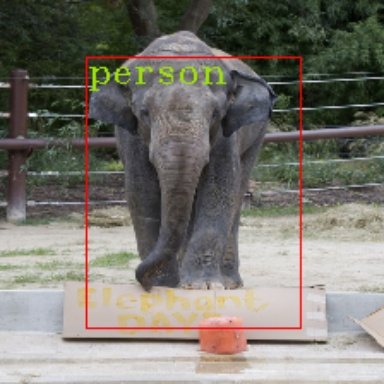

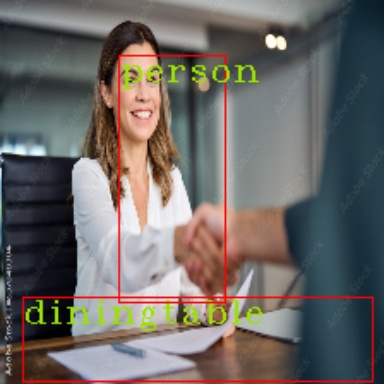

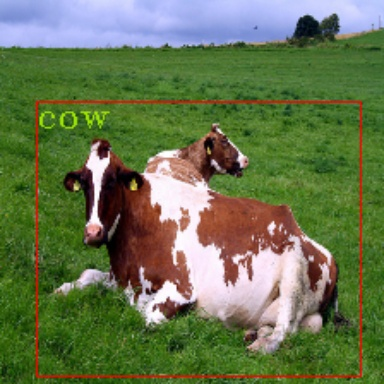

In [124]:
from google.colab.patches import cv2_imshow
outputs_path = '/content/outputs/'
images = [f for f in os.listdir(outputs_path) if f.endswith('.jpg')]
for file in images:
  output = cv2.imread(outputs_path + file)
  cv2_imshow(output)

The accuracy is not the best due to overfitting becuase of train_loss and val_loss making a big gap but still does well.